In [1]:

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import pickle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier


from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import AdaBoostClassifier

# SVM
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier





from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
# import catboost
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/BackorderPrediction/dataset/Kaggle_Training_Dataset_v2.csv') 

In [ ]:
# data = pd.read_csv('dataset/Kaggle_Training_Dataset_v2.csv') 


In [4]:
print('Number of data points :', data.shape[0])
print('Number of varaiables :', data.shape[1])
print('Variabales', data.columns.values)

Number of data points : 1687861
Number of varaiables : 23
Variabales ['sku' 'national_inv' 'lead_time' 'in_transit_qty' 'forecast_3_month'
 'forecast_6_month' 'forecast_9_month' 'sales_1_month' 'sales_3_month'
 'sales_6_month' 'sales_9_month' 'min_bank' 'potential_issue'
 'pieces_past_due' 'perf_6_month_avg' 'perf_12_month_avg' 'local_bo_qty'
 'deck_risk' 'oe_constraint' 'ppap_risk' 'stop_auto_buy' 'rev_stop'
 'went_on_backorder']


In [ ]:
data.forecast_9_month.mean()

506.3644306992286

## Data Preprocessing 

### Replacing -99 values in perf_  and perf column as nan

In [5]:
data.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)
data.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)

In [6]:
data.drop(data.tail(1).index,inplace=True) 
data.drop(['sku'], axis = 1,inplace=True)

### converting categorical features as labels(YES to 1 and NO to 0)

In [7]:
cat_features = data.select_dtypes(include = ['object']).columns
for col in cat_features:
    data[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    data[col] = data[col].astype(int)

## Feature Engeenering

### Train test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:

X= data.drop(['went_on_backorder'], axis=1)
y = data.went_on_backorder
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state = 33 ,test_size=0.20, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,random_state = 33,test_size=0.10,stratify=y_train)


In [ ]:
X_train

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1437004,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.96,0.0,0,0,0,1,0
582719,7325.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,11.0,92.0,53.0,0,0.0,NaN,NaN,0.0,0,0,0,1,0
250698,190.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0.33,0.0,0,0,1,0,0
1599337,15.0,8.0,18.0,0.0,15.0,35.0,6.0,15.0,39.0,59.0,0.0,0,0.0,0.76,0.84,0.0,0,0,0,1,0
451811,10.0,12.0,0.0,2.0,10.0,14.0,4.0,5.0,8.0,16.0,3.0,0,0.0,0.93,0.95,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190510,230.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.98,0.97,0.0,0,0,0,1,0
486572,15.0,8.0,0.0,0.0,0.0,0.0,3.0,5.0,14.0,20.0,1.0,0,0.0,0.99,0.97,0.0,0,0,1,1,0
622924,190.0,2.0,0.0,0.0,0.0,0.0,10.0,34.0,47.0,84.0,0.0,0,0.0,NaN,NaN,0.0,0,0,0,1,0
330428,34.0,NaN,0.0,0.0,0.0,0.0,2.0,13.0,33.0,49.0,8.0,0,0.0,NaN,NaN,0.0,0,0,0,0,0


### Missing values imputation

In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [11]:
%%time
df = X_train
imp = IterativeImputer(max_iter=10, verbose=0)
imp = imp.fit(X_train)
imputed_X_train = imp.transform(X_train)
imputed_X_test = imp.transform(X_test)
imputed_X_cv = imp.transform(X_cv)


X_train = pd.DataFrame(imputed_X_train, columns=df.columns)
X_test = pd.DataFrame(imputed_X_test, columns=df.columns)
X_cv = pd.DataFrame(imputed_X_cv, columns=df.columns)




CPU times: user 1min 4s, sys: 33.5 s, total: 1min 37s
Wall time: 34.1 s


In [12]:
filename = '/content/drive/MyDrive/BackorderPrediction/Imputer_New.pkl'
pickle.dump(imp, open(filename, 'wb'))

In [ ]:
import joblib

In [ ]:
# filename = 'finalized_model.sav'
filename = '/content/drive/MyDrive/BackorderPrediction/Imputer_joblib.pkl'

joblib.dump(imp, filename)

In [ ]:
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer.fit(X_train)
# X_train = imputer.transform(X_train)
# X_test = imputer.transform(X_test)


In [ ]:
%%time
X_train

Wall time: 0 ns


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,8.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.990000,0.960000,0.0,0.0,0.0,0.0,1.0,0.0
1,7325.0,7.177643,0.0,0.0,0.0,0.0,0.0,0.0,11.0,92.0,...,0.0,0.0,0.783932,0.781573,0.0,0.0,0.0,0.0,1.0,0.0
2,190.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.340934,0.330000,0.0,0.0,0.0,1.0,0.0,0.0
3,15.0,8.000000,18.0,0.0,15.0,35.0,6.0,15.0,39.0,59.0,...,0.0,0.0,0.760000,0.840000,0.0,0.0,0.0,0.0,1.0,0.0
4,10.0,12.000000,0.0,2.0,10.0,14.0,4.0,5.0,8.0,16.0,...,0.0,0.0,0.930000,0.950000,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215254,230.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.980000,0.970000,0.0,0.0,0.0,0.0,1.0,0.0
1215255,15.0,8.000000,0.0,0.0,0.0,0.0,3.0,5.0,14.0,20.0,...,0.0,0.0,0.990000,0.970000,0.0,0.0,0.0,1.0,1.0,0.0
1215256,190.0,2.000000,0.0,0.0,0.0,0.0,10.0,34.0,47.0,84.0,...,0.0,0.0,0.783131,0.779781,0.0,0.0,0.0,0.0,1.0,0.0
1215257,34.0,20.362122,0.0,0.0,0.0,0.0,2.0,13.0,33.0,49.0,...,0.0,0.0,0.752492,0.756802,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
count,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06,1.215259e+06
mean,4.923974e+02,8.071842e+00,4.514353e+01,1.801604e+02,3.489645e+02,5.121952e+02,5.690991e+01,1.782269e+02,3.469212e+02,5.348089e+02,5.340802e+01,5.258138e-04,2.122755e+00,7.800174e-01,7.763251e-01,6.221777e-01,2.295165e-01,1.505852e-04,1.209923e-01,9.637559e-01,4.427040e-04
std,2.939521e+04,7.009007e+00,1.381523e+03,5.018274e+03,9.857124e+03,1.452271e+04,1.970215e+03,5.368683e+03,9.877155e+03,1.528198e+04,1.287343e+03,2.292461e-02,2.581694e+02,2.303372e-01,2.218362e-01,3.388277e+01,4.205221e-01,1.227040e-02,3.261185e-01,1.868971e-01,2.103588e-02
min,-2.725600e+04,-3.535940e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.300000e-01,7.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.600000e+01,3.000000e+00,0.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.876800e+05,1.218328e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.000000e+00,1.464960e+05,1.024611e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# Modeling 

## Base model on RAW data 

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.01,0.1,0,1.0,10.0,100.0,1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
logreg = clf.fit(X_train, y_train)
print("Best Params:" , logreg.best_params_)
print("Best Score:" , logreg.best_score_)

Best Params :  {'C': 1000.0, 'penalty': 'l2'}
Best Score :  0.686929440797646
CPU times: user 27.4 s, sys: 14.3 s, total: 41.8 s
Wall time: 37min 7s


In [ ]:
clf.best_params_['C']

1000.0

In [ ]:
model = LogisticRegression(penalty = logreg.best_params_['penalty'],C = logreg.best_params_['C'], n_jobs=-1)
model.fit(X_train, y_train)



LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/LogisticRegression_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [18]:

filename = '/content/drive/MyDrive/BackorderPrediction/LogisticRegression_model.pkl'

modelLog = pickle.load(open(filename, 'rb'))




Logistic: ROC AUC=0.671


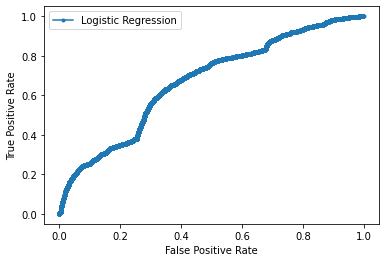

The ROC-AUC Score obtained on CV set is :  0.49987921732828733
CPU times: user 745 ms, sys: 623 ms, total: 1.37 s
Wall time: 662 ms


In [21]:
%%time
lr_probs = modelLog.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

Logistic: f1=0.000 auc=0.016


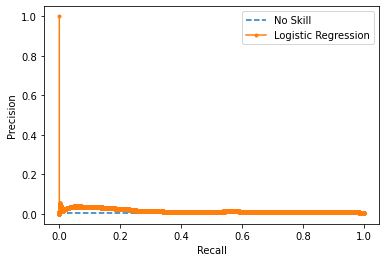

In [ ]:
lr_probs = modelLog.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
yhat = modelLog.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

### SMOTE

In [22]:
from imblearn.combine import SMOTETomek

In [ ]:
#  pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
smotemek = SMOTETomek(sampling_strategy='auto')


X_train_smt, y_train_smt = smotemek.fit_resample(X_train, y_train)
np.save('X_train_smt.npy', X_train_smt) 
np.save('y_train_smt.npy', y_train_smt)

In [23]:

X_train_smt = np.load('/content/drive/MyDrive/BackorderPrediction/X_train_smt.npy') # load
y_train_smt = np.load('/content/drive/MyDrive/BackorderPrediction/y_train_smt.npy') # load

In [ ]:

X_train_smt = np.load('X_train_smt.npy') # load
y_train_smt = np.load('y_train_smt.npy') # load

In [ ]:
%time
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.01,0.1,0,1.0,10.0,100.0,1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
logregsmt = clf.fit(X_train_smt, y_train_smt)
print("Best Params : " , logregsmt.best_params_)
print("Best Score : " , logregsmt.best_score_)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs
Best Params :  {'C': 0.01, 'penalty': 'l2'}
Best Score :  0.8996264726612834


In [ ]:
model = LogisticRegression(penalty = logregsmt.best_params_['penalty'],C = logregsmt.best_params_['C'],n_jobs=-1)
model.fit(X_train_smt, y_train_smt)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
import pickle
# /content/drive/MyDrive/BackorderPrediction/FE and Modeling Backorder prediction.ipynb

In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/LogisticRegressionwithSMOTE_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [24]:


filename = '/content/drive/MyDrive/BackorderPrediction/LogisticRegressionwithSMOTE_model.pkl'

modelLogSMOTE = pickle.load(open(filename, 'rb'))




Logistic with SMOTE: ROC AUC=0.812


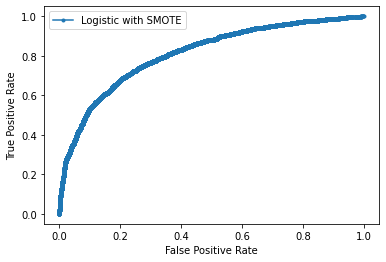

The ROC-AUC Score obtained on CV set is :  0.8250510185386416
CPU times: user 692 ms, sys: 539 ms, total: 1.23 s
Wall time: 632 ms


In [63]:
%%time
lr_probs = modelLogSMOTE.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic with SMOTE: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic with SMOTE')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

print("The ROC-AUC Score obtained on CV set is : " , roc_auc_score(y_cv, modelLogSMOTE.decision_function(X_cv)))




Logistic with SMOTE: f1=0.042 auc=0.075


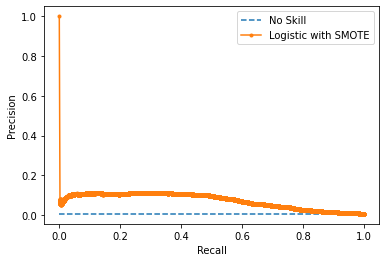

In [34]:
lr_probs = modelLogSMOTE.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
yhat = modelLogSMOTE.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('Logistic with SMOTE: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic with SMOTE')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [39]:
num_features = ['national_inv' , 'in_transit_qty' , 'forecast_3_month','forecast_6_month','forecast_9_month' , 'sales_1_month','sales_3_month','sales_6_month','sales_9_month' , 'min_bank','pieces_past_due','local_bo_qty']

## Log transform

In [40]:
# Copying data to try and apply log transform 
X_train_log, X_cv_log,X_test_log, y_train_log, y_cv_log , y_test_log = X_train, X_cv,X_test, y_train, y_cv , y_test


In [58]:
X_train

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,2.197225,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.990000,0.960000,0.0,0.0,0.0,0.0,1.0,0.0
1,8.899185,7.177643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.484907,4.532599,3.988984,0.0,0.0,0.783932,0.781573,0.0,0.0,0.0,0.0,1.0,0.0
2,5.252273,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.340934,0.330000,0.0,0.0,0.0,1.0,0.0,0.0
3,2.772589,8.000000,2.944439,0.000000,2.772589,3.583519,1.945910,2.772589,3.688879,4.094345,0.000000,0.0,0.0,0.760000,0.840000,0.0,0.0,0.0,0.0,1.0,0.0
4,2.397895,12.000000,0.000000,1.098612,2.397895,2.708050,1.609438,1.791759,2.197225,2.833213,1.386294,0.0,0.0,0.930000,0.950000,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215254,5.442418,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.980000,0.970000,0.0,0.0,0.0,0.0,1.0,0.0
1215255,2.772589,8.000000,0.000000,0.000000,0.000000,0.000000,1.386294,1.791759,2.708050,3.044522,0.693147,0.0,0.0,0.990000,0.970000,0.0,0.0,0.0,1.0,1.0,0.0
1215256,5.252273,2.000000,0.000000,0.000000,0.000000,0.000000,2.397895,3.555348,3.871201,4.442651,0.000000,0.0,0.0,0.783131,0.779781,0.0,0.0,0.0,0.0,1.0,0.0
1215257,3.555348,20.362122,0.000000,0.000000,0.000000,0.000000,1.098612,2.639057,3.526361,3.912023,2.197225,0.0,0.0,0.752492,0.756802,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_train_log

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,8.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.990000,0.960000,0.0,0.0,0.0,0.0,1.0,0.0
1,7325.0,7.177643,0.0,0.0,0.0,0.0,0.0,0.0,11.0,92.0,53.0,0.0,0.0,0.783932,0.781573,0.0,0.0,0.0,0.0,1.0,0.0
2,190.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.340934,0.330000,0.0,0.0,0.0,1.0,0.0,0.0
3,15.0,8.000000,18.0,0.0,15.0,35.0,6.0,15.0,39.0,59.0,0.0,0.0,0.0,0.760000,0.840000,0.0,0.0,0.0,0.0,1.0,0.0
4,10.0,12.000000,0.0,2.0,10.0,14.0,4.0,5.0,8.0,16.0,3.0,0.0,0.0,0.930000,0.950000,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215254,230.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.980000,0.970000,0.0,0.0,0.0,0.0,1.0,0.0
1215255,15.0,8.000000,0.0,0.0,0.0,0.0,3.0,5.0,14.0,20.0,1.0,0.0,0.0,0.990000,0.970000,0.0,0.0,0.0,1.0,1.0,0.0
1215256,190.0,2.000000,0.0,0.0,0.0,0.0,10.0,34.0,47.0,84.0,0.0,0.0,0.0,0.783131,0.779781,0.0,0.0,0.0,0.0,1.0,0.0
1215257,34.0,20.362122,0.0,0.0,0.0,0.0,2.0,13.0,33.0,49.0,8.0,0.0,0.0,0.752492,0.756802,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# sign = np.sign(data[num_features])
# sign

,national_inv,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,local_bo_qty
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1687856,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1687857,-1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1687858,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
# def log_transform(a):
#   print(a[num_features])
#   sign = np.sign(a[num_features])
#   a[num_features] =  int(np.log(0.000001+abs(a[num_features]))*sign)
  
#   return a

In [ ]:
# X_train_log[num_features]

,national_inv,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,local_bo_qty
0,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,8.899185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.484907,4.532599,3.988984,0.0,0.0
2,5.252273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,2.772589,2.944439,0.000000,2.772589,3.583519,1.945910,2.772589,3.688879,4.094345,0.000000,0.0,0.0
4,2.397895,0.000000,1.098612,2.397895,2.708050,1.609438,1.791759,2.197225,2.833213,1.386294,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1215254,5.442418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1215255,2.772589,0.000000,0.000000,0.000000,0.000000,1.386294,1.791759,2.708050,3.044522,0.693147,0.0,0.0
1215256,5.252273,0.000000,0.000000,0.000000,0.000000,2.397895,3.555348,3.871201,4.442651,0.000000,0.0,0.0
1215257,3.555348,0.000000,0.000000,0.000000,0.000000,1.098612,2.639057,3.526361,3.912023,2.197225,0.0,0.0


In [42]:
skewed_features = ['national_inv' , 'in_transit_qty' , 'forecast_3_month','forecast_6_month','forecast_9_month' , 'sales_1_month','sales_3_month','sales_6_month','sales_9_month' , 'min_bank','pieces_past_due','local_bo_qty']
log_columns = []
for i in skewed_features:
  log_columns.append(X_train.columns.get_loc(i))
log_columns

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]

In [43]:
def log_transform(a):
  # print(a[log_columns])
  sign = np.sign(a[log_columns])
  # print(sign)
  a[log_columns] =  np.log(1.0+abs(a[log_columns]))*sign

  return a

In [44]:
%%time
X_train_log = np.apply_along_axis(log_transform, 1, X_train_log)
X_cv_log = np.apply_along_axis(log_transform, 1, X_cv_log)
X_test_log = np.apply_along_axis(log_transform, 1, X_test_log)


CPU times: user 29.7 s, sys: 5.28 s, total: 35 s
Wall time: 29.8 s


Standard scaler

In [45]:
scaler = StandardScaler().fit(X_train_log)
X_train_log = scaler.transform(X_train_log)
X_cv_log = scaler.transform(X_cv_log)
X_test_log = scaler.transform(X_test_log)

## Logistic regression with Log transform

In [ ]:
%%time
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.01,0.1,0,1.0,10.0,100.0,1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
logreglog = clf.fit(X_train_log, y_train_log)
print("Best Params:" , logreglog.best_params_)
print("Best Score :" , logreglog.best_score_)

Best Params: {'C': 0.01, 'penalty': 'l2'}
Best Score : 0.9240550847626532
CPU times: user 19.3 s, sys: 14.3 s, total: 33.7 s
Wall time: 17min 7s


In [ ]:
model = LogisticRegression(penalty = logreglog.best_params_['penalty'],C = logreglog.best_params_['C'],n_jobs=-1)
model.fit(X_train_log, y_train_log)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/LogisticRegressionwithLOG_SMOTE_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/LogisticRegressionwithLOG_SMOTE_model.pkl'

modelLogLog = pickle.load(open(filename, 'rb'))


Logistic with Log transform: ROC AUC=0.921


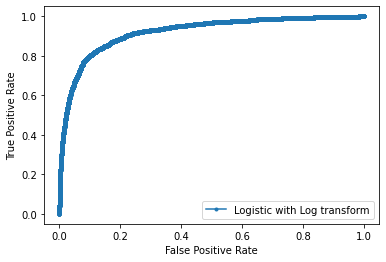

CPU times: user 701 ms, sys: 343 ms, total: 1.04 s
Wall time: 687 ms


In [ ]:
%%time
lr_probs = modelLogLog.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic with Log transform: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic with Log transform')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

Logistic: f1=0.053 auc=0.150


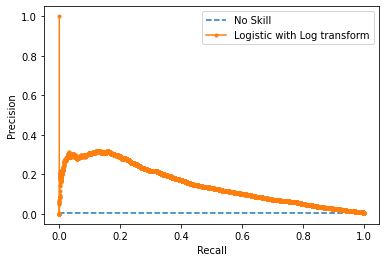

In [ ]:
lr_probs = modelLogLog.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
yhat = modelLogLog.predict(X_test_log)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('Logistic with Log transform: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic with Log transform')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## Balanced Bagging

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier

In [ ]:
%%time
model = BalancedBaggingClassifier(n_jobs = -1)
parameters = {'n_estimators' : [10,50,100,200,300,500,1000]}
clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
blag = clf.fit(X_train_log, y_train_log)
print("Best Params : " , blag.best_params_)
print("Best Score : " , blag.best_score_)

Best Params :  {'n_estimators': 1000}
Best Score :  0.9686900956437547
CPU times: user 58.8 s, sys: 12.8 s, total: 1min 11s
Wall time: 1h 9min 21s


In [ ]:
model = BalancedBaggingClassifier(n_estimators = blag.best_params_['n_estimators'],n_jobs=-1)
model.fit(X_train_log, y_train_log)


BalancedBaggingClassifier(base_estimator=None, bootstrap=True,
                          bootstrap_features=False, max_features=1.0,
                          max_samples=1.0, n_estimators=1000, n_jobs=-1,
                          oob_score=False, random_state=None, ratio=None,
                          replacement=False, sampling_strategy='auto',
                          verbose=0, warm_start=False)

In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/BalancedBaggingwithLOG_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/BalancedBaggingwithLOG_model.pkl'

In [ ]:
modelBlag = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

Blag: ROC AUC=0.971


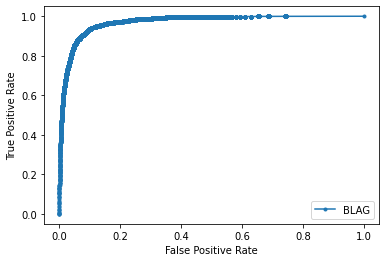

CPU times: user 2.53 s, sys: 451 ms, total: 2.98 s
Wall time: 51.1 s


In [ ]:
%%time
lr_probs = modelBlag.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Blag: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='BLAG')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

BLAG: f1=0.130 auc=0.328


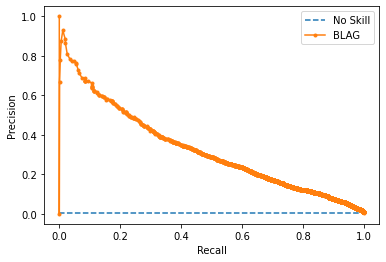

CPU times: user 4.65 s, sys: 1.01 s, total: 5.66 s
Wall time: 1min 47s


In [ ]:
%%time
lr_probs = modelBlag.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
yhat = modelBlag.predict(X_test_log)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('BLAG: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='BLAG')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## Random Forest with Balanced sub-sample

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time 

model = RandomForestClassifier(class_weight = "balanced_subsample" , n_jobs = -1 )
parameters = {'n_estimators' : [10,50,100,300,500,1000] , 'max_depth' : [1,3,5,7]}
# %time

clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
rf = clf.fit(X_train_log, y_train)
print("Best Params : " , rf.best_params_)
print("Best Score : " , rf.best_score_)

Best Params :  {'max_depth': 7, 'n_estimators': 1000}
Best Score :  0.9353209858463766
CPU times: user 1h 17min 40s, sys: 51.6 s, total: 1h 18min 31s
Wall time: 5h 49min 42s


In [ ]:
model = RandomForestClassifier(n_estimators = rf.best_params_['n_estimators'],max_depth =rf.best_params_['max_depth'],class_weight = "balanced_subsample", n_jobs=-1)
model.fit(X_train_log, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/RandamForestBalancedwithLOG_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [47]:
filename = '/content/drive/MyDrive/BackorderPrediction/RandamForestBalancedwithLOG_model.pkl'

modelRand = pickle.load(open(filename, 'rb'))

Random Forest: ROC AUC=0.917


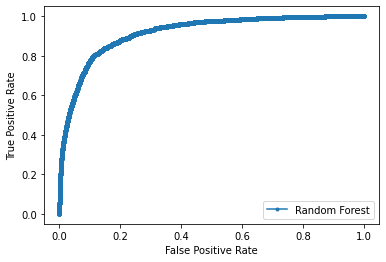

The ROC-AUC Score obtained on CV set is :  0.9142607910259223
CPU times: user 54.1 s, sys: 515 ms, total: 54.7 s
Wall time: 14.6 s


In [50]:
%%time
lr_probs = modelRand.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()
print("The ROC-AUC Score obtained on CV set is : " , roc_auc_score(y_cv, modelRand.predict_proba(X_cv_log)[:, 1]))


Random Forest: f1=0.073 auc=0.141


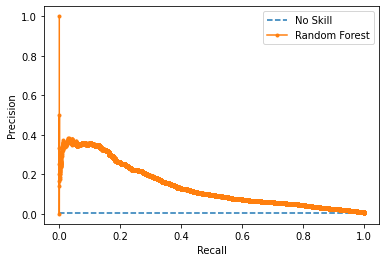

CPU times: user 1min 17s, sys: 539 ms, total: 1min 18s
Wall time: 20.6 s


In [51]:
%%time
lr_probs = modelRand.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
yhat = modelRand.predict(X_test_log)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
%%time
model = AdaBoostClassifier()
parameters = {'n_estimators' : [10,50,100,300,500,1000]}
clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
adab = clf.fit(X_train_log, y_train)
print("Best Params : " , adab.best_params_)
print("Best Score : " , adab.best_score_)

Best Params :  {'n_estimators': 1000}
Best Score :  0.9326726556086766
CPU times: user 4h 37min 48s, sys: 49.2 s, total: 4h 38min 37s
Wall time: 4h 38min 16s


In [ ]:
%%time
model = AdaBoostClassifier(n_estimators = adab.best_params_['n_estimators'])
model.fit(X_train_log, y_train)

CPU times: user 31min 5s, sys: 3.02 s, total: 31min 9s
Wall time: 31min 4s


In [ ]:
filename = '/content/drive/MyDrive/BackorderPrediction/AdaBoostwithLOG_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [56]:
filename = '/content/drive/MyDrive/BackorderPrediction/AdaBoostwithLOG_model.pkl'

modelAda = pickle.load(open(filename, 'rb'))

AdaBoost: ROC AUC=0.921


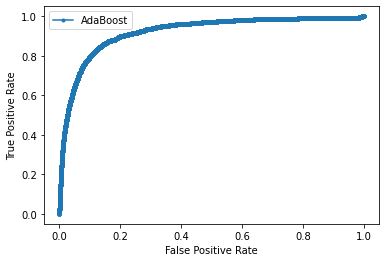

The ROC-AUC Score obtained on CV set is :  0.9289334829686682
CPU times: user 1min 25s, sys: 890 ms, total: 1min 26s
Wall time: 1min 26s


In [57]:
%%time
lr_probs = modelAda.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('AdaBoost: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='AdaBoost')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()
print("The ROC-AUC Score obtained on CV set is : " , roc_auc_score(y_cv, modelAda.decision_function(X_cv_log)))


AdaBoost: f1=0.049 auc=0.033


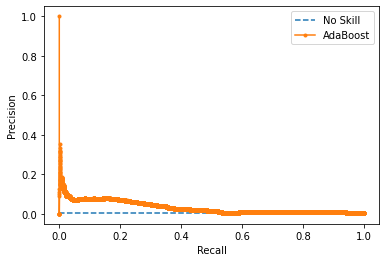

CPU times: user 1min 57s, sys: 634 ms, total: 1min 58s
Wall time: 1min 58s


In [ ]:
%%time
lr_probs = modelAda.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
yhat = modelAda.predict(X_test_log)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('AdaBoost: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='AdaBoost')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## DT

In [ ]:
%%time
model = DecisionTreeClassifier(class_weight='balanced', random_state=22)
parameters = {'criterion' : ['gini', 'entropy'],
             "max_depth": range(1,10),
             "min_samples_split": range(1,10),
             "min_samples_leaf": range(1,5)
             }
clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
dt = clf.fit(X_train_log, y_train)
print("Best Params : " , dt.best_params_)
print("Best Score : " , dt.best_score_)

Best Params :  {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score :  0.9333720326605361
Wall time: 4h 3min 1s


In [ ]:
%%time
model = DecisionTreeClassifier(class_weight='balanced', random_state=22,criterion=dt.best_params_['criterion'], max_depth = dt.best_params_['max_depth'], min_samples_split=dt.best_params_['min_samples_split'],
                               min_samples_leaf=dt.best_params_['min_samples_leaf'])
                               
model.fit(X_train_log, y_train)

Wall time: 8.72 s


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, random_state=22)

In [ ]:
filename = 'DTwithLOG_model.pkl'
pickle.dump(model, open(filename, 'wb'))

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
filename = 'DTwithLOG_model.pkl'

modelDt = pickle.load(open(filename, 'rb'))

DT: ROC AUC=0.931


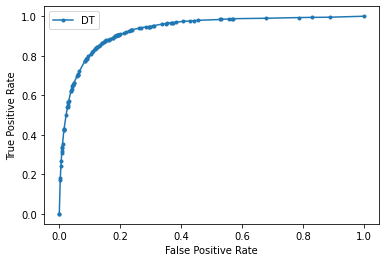

Wall time: 252 ms


In [ ]:
%%time
lr_probs = modelDt.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('DT: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DT')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

DT: f1=0.074 auc=0.208


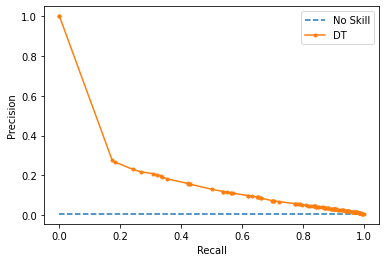

Wall time: 272 ms


In [ ]:
%%time
lr_probs = modelDt.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
yhat = modelDt.predict(X_test_log)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('DT: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='DT')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## LGBM

In [ ]:
!pip install lightgbm

In [ ]:
# import lightgbm as lgb

In [ ]:
!pip install hyperopt

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491062 sha256=ea5558d3c045ab917c46576af7dce82e644061f71521176ea5745a6541d76144
  Stored in directory: c:\users\vrtrix\appdata\local\pip\cache\wheels\56\b0\fe\4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future


In [ ]:
def gb_mse_cv(space):
    model = lgb.LGBMClassifier(n_estimators = int(space['n_estimators']),
                             max_depth = int(space['max_depth']),
                             learning_rate= space['learning_rate'],                              
                              num_leaves= int(space['num_leaves']),
                              reg_alpha = space['reg_alpha'],
                              reg_lambda = space['reg_lambda'],
                              colsample_bytree = space['colsample_bytree'],
                              min_child_weight = space['min_child_weight']                              
                             )
    score = cross_val_score(model, X_train_log, y_train, cv=10, scoring= "roc_auc").mean()
    return score

In [ ]:
%%time
space = {'n_estimators': hp.quniform('n_estimators', 100,200,1),
         'max_depth': hp.quniform("max_depth", 2,8,1),
         'learning_rate': hp.loguniform("learning_rate", -4,-1),
#          'gamma': hp.quniform('gamma',0.1,0.5, 0.1),
         'num_leaves': hp.quniform('num_leaves', 30,50,1),
         'reg_alpha':hp.quniform('reg_alpha',1.1,1.5,0.1),
         'reg_lambda':hp.uniform('reg_lambda',1.1,1.5),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.1,0.5),
         'min_child_weight': hp.quniform('min_child_weight', 0,10,1)}

trials = Trials()

best= fmin(fn=gb_mse_cv,
          space=space,
          algo= tpe.suggest,
          max_evals= 20,
          trials= trials
          )

100%|██████████| 20/20 [17:54<00:00, 53.74s/trial, best loss: -0.9620168403322532]
Wall time: 17min 54s


In [ ]:
print("the best Hyperparameters are: ","\n" )
print(best)

the best Hyperparameters are:  

{'colsample_bytree': 0.4946318706719163, 'learning_rate': 0.3170029409002925, 'max_depth': 7.0, 'min_child_weight': 2.0, 'n_estimators': 136.0, 'num_leaves': 43.0, 'reg_alpha': 1.2000000000000002, 'reg_lambda': 1.3087826920983168}


In [ ]:
model = lgb.LGBMClassifier(n_estimators = int(best['n_estimators']),
                             max_depth = int(best['max_depth']),
                             learning_rate= best['learning_rate'],                              
                              num_leaves= int(best['num_leaves']),
                              reg_alpha = best['reg_alpha'],
                              reg_lambda = best['reg_lambda'],
                              colsample_bytree = best['colsample_bytree'],
                              min_child_weight = best['min_child_weight']                              
                             )
model.fit(X_train_log, y_train)



LGBMClassifier(colsample_bytree=0.4946318706719163,
               learning_rate=0.3170029409002925, max_depth=7,
               min_child_weight=2.0, n_estimators=136, num_leaves=43,
               reg_alpha=1.2000000000000002, reg_lambda=1.3087826920983168)

In [ ]:
filename = 'LGBMLOG_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = 'LGBMLOG_model.pkl'

modelLgbm = pickle.load(open(filename, 'rb'))

DT: ROC AUC=0.962


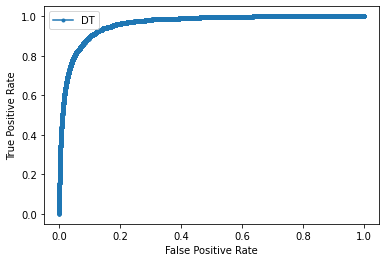

Wall time: 766 ms


In [ ]:
%%time
lr_probs = modelLgbm.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('LGBM: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

DT: f1=0.189 auc=0.309


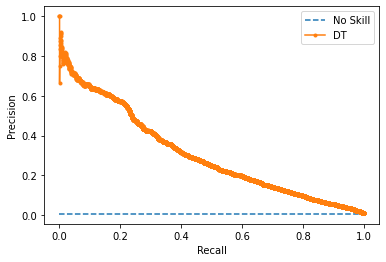

Wall time: 1.3 s


In [ ]:
%%time
lr_probs = modelLgbm.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
yhat = modelLgbm.predict(X_test_log)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('LGBM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LGBM')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## GassuianNB

In [ ]:
%%time
model = GaussianNB()
parameters =  {'var_smoothing': np.logspace(0,-9, num=100)}
clf = GridSearchCV(model, parameters,scoring = 'roc_auc',verbose=10 )
nb = clf.fit(X_train_log, y_train)
print("Best Params : " , nb.best_params_)
print("Best Score : " , nb.best_score_)

In [ ]:
%%time
model = GaussianNB(var_smoothing=nb.best_params_['var_smoothing'])
                               
model.fit(X_train_log, y_train)

Wall time: 515 ms


GaussianNB(var_smoothing=0.0004328761281083057)

In [ ]:
filename = 'NBwithLOG_model.pkl'
pickle.dump(model, open(filename, 'wb'))

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
filename = 'NBwithLOG_model.pkl'

modelNB = pickle.load(open(filename, 'rb'))

GaussianNB: ROC AUC=0.882


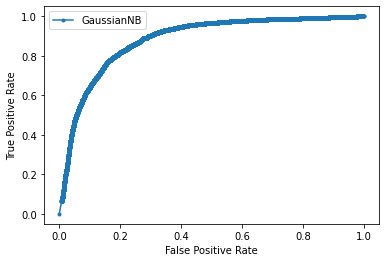

Wall time: 434 ms


In [ ]:
%%time
lr_probs = modelNB.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('GaussianNB: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='GaussianNB')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

GaussianNB: f1=0.101 auc=0.076


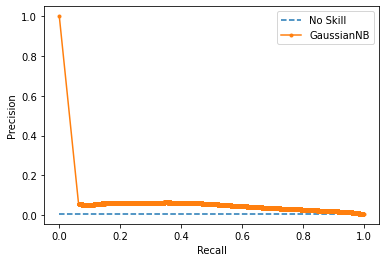

Wall time: 751 ms


In [ ]:
%%time
lr_probs = modelNB.predict_proba(X_test_log)
lr_probs = lr_probs[:, 1]
yhat = modelNB.predict(X_test_log)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('GaussianNB: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='GaussianNB')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [ ]:
!pip install PrettyTable

## Custom ensembel 1


In [ ]:

data_y = data['went_on_backorder']
X_train, X_test, y_train, y_test = train_test_split(data.drop(['went_on_backorder'], axis=1), data_y , random_state = 42 , stratify=data_y,test_size=0.20)
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train,random_state = 42 ,stratify=y_train,test_size=0.50)

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train1)

IterativeImputer(random_state=0)

In [ ]:

X_train1 = imp.transform(X_train1)
X_test = imp.transform(X_test)
X_train2 = imp.transform(X_train2)

In [ ]:
num_features = ['national_inv' , 'in_transit_qty' , 'forecast_3_month','forecast_6_month','forecast_9_month' , 'sales_1_month','sales_3_month','sales_6_month','sales_9_month' , 'min_bank','pieces_past_due','local_bo_qty']

## Log transform

In [ ]:
# Copying data to try and apply log transform 
X_train1_log, X_train2_log,X_test_log, y_train1_log, y_train2_log , y_test_log = X_train1, X_train2,X_test, y_train1, y_train2 , y_test


In [ ]:
skewed_features = ['national_inv' , 'in_transit_qty' , 'forecast_3_month','forecast_6_month','forecast_9_month' , 'sales_1_month','sales_3_month','sales_6_month','sales_9_month' , 'min_bank','pieces_past_due','local_bo_qty']
log_columns = []
for i in skewed_features:
  log_columns.append(X_train.columns.get_loc(i))
log_columns

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]

In [ ]:
def log_transform(a):
  # print(a[log_columns])
  sign = np.sign(a[log_columns])
  # print(sign)
  a[log_columns] =  np.log(1.0+abs(a[log_columns]))*sign

  return a

In [ ]:
%%time
X_train1_log = np.apply_along_axis(log_transform, 1, X_train1_log)
X_train2_log = np.apply_along_axis(log_transform, 1, X_train2_log)
X_test_log = np.apply_along_axis(log_transform, 1, X_test_log)


Wall time: 24.7 s


Standard scaler

In [ ]:
scaler = StandardScaler().fit(X_train1_log)
X_train1_log = scaler.transform(X_train1_log)
X_train2_log = scaler.transform(X_train2_log)
X_test_log = scaler.transform(X_test_log)

In [ ]:
BLAG_base = BalancedBaggingClassifier(n_estimators = 1000, n_jobs=-1)
DT = DecisionTreeClassifier(class_weight='balanced', random_state=22,criterion= 'entropy', max_depth= 7, min_samples_leaf=1, min_samples_split=2)
# DT_meta =DecisionTreeClassifier()
BLAG_meta = BalancedBaggingClassifier( n_jobs=-1)

LR_meta = LogisticRegression(n_jobs = -1)
GNB= GaussianNB(var_smoothing=0.0004328761281083057)
LGBM = lgbm.LGBMClassifier(colsample_bytree=0.4946318706719163,
               learning_rate=0.3170029409002925, max_depth=7,
               min_child_weight=2.0, n_estimators=136, num_leaves=43,
               reg_alpha=1.2000000000000002, reg_lambda=1.3087826920983168)
RF_base=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
CatBoost_base =catboost.CatBoostClassifier(
                                    loss_function='Logloss',
                                    use_best_model=False,
                                    task_type="GPU",                                    
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count= 245, 
                                    depth= 5.0, 
                                    l2_leaf_reg= 7.585550468897254,
                                    learning_rate=0.06124494852288338
                                    )
XGB = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=18,
 min_child_weight=1, gamma=0.1, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [ ]:
class custom_ensemble1:

  def __init__(self,base_models,meta_model,number_of_splits):

    self.base_models = base_models
#     self.base_model2 = base_model2
    
    self.meta_model = meta_model
    self.number_of_splits = number_of_splits
#     self.bootstrap_size = bootstrap_size
  
  def split_dataset(self,X,y):

    X_samples = []
    y_samples = []

    
    for i in range(self.number_of_splits): 
      subsample = []
      lst = [0,1]
      for j in lst:
        samples = np.where(y.values==j)[0]
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=int(len(X)/(self.number_of_splits*2)), replace=True)
        subsample.extend(samples[indexes])
      X_samples.append(X[subsample])
      y_samples.append(y.values[subsample])
    
    return X_samples , y_samples

  def base_models_fit(self,X_samples,y_samples):
        
        weak_learners = []
        models = self.base_models
        for i in range(len(models)):
            curr_model = models[i]
            weak_learners.append(curr_model.fit(X_samples[i],y_samples[i]))
        return weak_learners


  def create_meta_dataset(self,weak_learners , X_train2 , y_train2):

    meta_x = []
    meta_y = []

    
    for j in range(len(weak_learners)):
        pred = weak_learners[j].predict(X_train2)
        meta_x.append(pred)
        meta_y.append(np.array(y_train2))
    print(meta_x) 
    meta_data_x = np.array(list(zip(*meta_x)))
    
    return meta_data_x,meta_y[0]
  
  def meta_model_fit(self,meta_x,meta_y):
    
    
       
    model = self.meta_model.fit(meta_x, meta_y)
    print(meta_y.shape)
    print(meta_y)
    pred = model.predict(meta_x)
    print(pred)
    print("ROC-AUC score after fitting meta model : " , roc_auc_score(meta_y, pred))
    return model

In [ ]:
custom_model = custom_ensemble1([BLAG_base,RF_base,XGB,CatBoost_base,LGBM,DT],LR_meta,6)
# custom_model = custom_ensemble1([BLAG_base,RF_base,XGB,CatBoost_base,LGBM],DT,5) Pr-Re Auc - 0.405



In [ ]:
D1_X,D1_y = custom_model.split_dataset(X_train1_log,y_train1)


In [ ]:
%%time
base_learners = custom_model.base_models_fit(D1_X,D1_y)


[17:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6468199	total: 6.7ms	remaining: 6.7s
999:	learn: 0.1814738	total: 6.21s	remaining: 0us
Wall time: 4min 56s


In [ ]:
base_learners

[BalancedBaggingClassifier(n_estimators=1000, n_jobs=-1),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                        n_estimators=1000, n_jobs=-1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=18,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=27, subsample=0.9, tree_method='exact',
               validate_parameters=1, verbosity=None),
 LGBMClassifier(colsample_bytree=0.4946318706719163,
                learning_rate=0.3170029409002925, max_depth=7,
                min_child_weight=2.0, n_estimators=136, num_leaves=43,
 

In [ ]:
%%time
D2_X,D2_y = custom_model.create_meta_dataset(base_learners,X_train2_log,y_train2)

[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0])]
Wall time: 2min 7s


In [ ]:
D2_X.shape

(675144, 6)

In [ ]:
D2_y.shape

(675144,)

In [ ]:
%%time
meta_model_final = custom_model.meta_model_fit(D2_X,D2_y)

(675144,)
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
ROC-AUC score after fitting meta model :  0.5
Wall time: 2.02 s


In [ ]:
filename = 'CE_model.pkl'
pickle.dump(meta_model_final, open(filename, 'wb'))

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
filename = 'CE_model.pkl'

modelCE = pickle.load(open(filename, 'rb'))

In [ ]:

D2_X,D2_y = [] , []

In [ ]:
%%time
test_X,test_y = custom_model.create_meta_dataset(base_learners,X_test_log,y_test)

[array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 1, 0])]
Wall time: 1min 4s


In [ ]:
test_X.shape

(337572, 6)

CE: ROC AUC=0.944


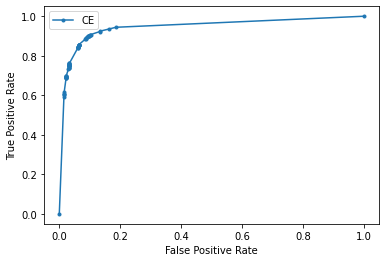

Wall time: 180 ms


In [ ]:
%%time
lr_probs = modelCE.predict_proba(test_X)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(test_y, lr_probs)
print('CE: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CE')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

CE: f1=0.000 auc=0.402


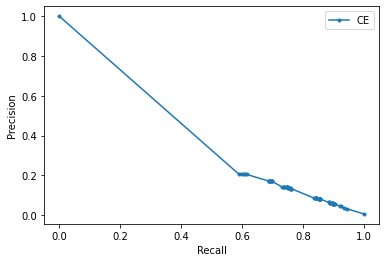

Wall time: 201 ms


In [ ]:
%%time
lr_probs = modelCE.predict_proba(test_X)
lr_probs = lr_probs[:, 1]
yhat = modelCE.predict(test_X)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, lr_probs)
lr_f1, lr_auc = f1_score(test_y, yhat), auc(lr_recall, lr_precision)
print('CE: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# no_skill = len(test_y[test_y==1]) / len(test_y)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='CE')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [ ]:
# custom_model = custom_ensemble1([BLAG_base,RF_base,XGB,CatBoost_base,DT],LR_meta,5)
custom_model = custom_ensemble1([BLAG_base,RF_base,XGB,CatBoost_base,LGBM],DT,5) #Pr-Re Auc - 0.405



In [ ]:
D1_X,D1_y = custom_model.split_dataset(X_train1_log,y_train1)


In [ ]:
%%time
base_learners = custom_model.base_models_fit(D1_X,D1_y)


[19:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6460471	total: 7.78ms	remaining: 7.77s
999:	learn: 0.1847925	total: 6.41s	remaining: 0us
Wall time: 6min 7s


In [ ]:
base_learners

[BalancedBaggingClassifier(n_estimators=1000, n_jobs=-1),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                        n_estimators=1000, n_jobs=-1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=18,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=27, subsample=0.9, tree_method='exact',
               validate_parameters=1, verbosity=None),
 LGBMClassifier(colsample_bytree=0.4946318706719163,
                learning_rate=0.3170029409002925, max_depth=7,
                min_child_weight=2.0, n_estimators=136, num_leaves=43,
 

In [ ]:
%%time
D2_X,D2_y = custom_model.create_meta_dataset(base_learners,X_train2_log,y_train2)

[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0])]
Wall time: 2min 9s


In [ ]:
D2_X.shape

(675144, 5)

In [ ]:
D2_y.shape

(675144,)

In [ ]:
# meta_model_final = custom_model.meta_model_fit(np.array(D2_X).reshape(-1,1) , np.array(D2_y).reshape(-1,1))

In [ ]:
%%time
meta_model_final = custom_model.meta_model_fit(D2_X,D2_y)

(675144,)
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
ROC-AUC score after fitting meta model :  0.9090971191459583
Wall time: 388 ms


In [ ]:
filename = 'CE_model.pkl'
pickle.dump(meta_model_final, open(filename, 'wb'))

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
filename = 'CE_model.pkl'

modelCE = pickle.load(open(filename, 'rb'))

In [ ]:

D2_X,D2_y = [] , []

In [ ]:
%%time
test_X,test_y = custom_model.create_meta_dataset(base_learners,X_test_log,y_test)

[array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0])]
Wall time: 1min 6s


In [ ]:
test_X.shape

(337572, 5)

CE: ROC AUC=0.942


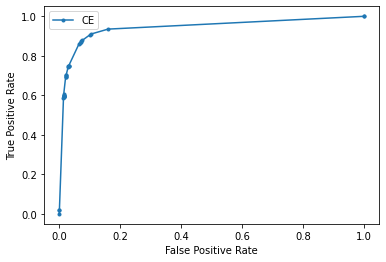

Wall time: 189 ms


In [ ]:
%%time
lr_probs = modelCE.predict_proba(test_X)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(test_y, lr_probs)
print('CE: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CE')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

CE: f1=0.108 auc=0.198


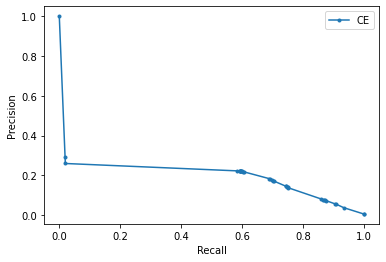

Wall time: 223 ms


In [ ]:
%%time
lr_probs = modelCE.predict_proba(test_X)
lr_probs = lr_probs[:, 1]
yhat = modelCE.predict(test_X)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, lr_probs)
lr_f1, lr_auc = f1_score(test_y, yhat), auc(lr_recall, lr_precision)
print('CE: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# no_skill = len(test_y[test_y==1]) / len(test_y)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='CE')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## Model Results

In [67]:
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = ["Model", "ROC AUC(Test)", " Pr-Re AUC(Test)"]

x.add_row(["Logistic Regression On RAW Data(Base model)",0.671,0.016 ])
x.add_row(["Logistic Regression On SMOTE Data",0.812,0.052 ])
x.add_row(["Logistic Regression With LOG transform",0.921,0.152 ])
x.add_row(["BLAG",0.971,0.328 ])
x.add_row(["RF With Balanced Sub sample",0.917,0.141 ])
x.add_row(["GassiuanNB",0.882,0.076 ])
x.add_row(["LGBM",0.962,0.309 ])
x.add_row(["DT",0.931,0.208 ])
x.add_row(["Custom Ensemble 1",0.942,0.198 ])


print(x)

+---------------------------------------------+---------------+------------------+
|                    Model                    | ROC AUC(Test) |  Pr-Re AUC(Test) |
+---------------------------------------------+---------------+------------------+
| Logistic Regression On RAW Data(Base model) |     0.671     |      0.016       |
|      Logistic Regression On SMOTE Data      |     0.812     |      0.052       |
|    Logistic Regression With LOG transform   |     0.921     |      0.152       |
|                     BLAG                    |     0.971     |      0.328       |
|         RF With Balanced Sub sample         |     0.917     |      0.141       |
|                  GassiuanNB                 |     0.882     |      0.076       |
|                     LGBM                    |     0.962     |      0.309       |
|                      DT                     |     0.931     |      0.208       |
|              Custom Ensemble 1              |     0.942     |      0.198       |
+---

## Conclusion

From all the model performances BLAG scored better with LOG trasformation data than the other models in Pe-Re AUC score.